# Introduction

This notebook presents a solution for the Matting Image Segmentation* task.

The goal is to predict a 1-channel alpha matte for a given RGB image, where pixel values lie in the range [0, 255].  
Unlike binary segmentation, the target masks contain soft transitions along object boundaries, which requires accurate edge-aware predictions.

The model is trained using publicly available matting and segmentation datasets.  
Performance is evaluated using **Mean Squared Error (MSE)**, which is the official competition metric.

The notebook covers:
- data preparation and preprocessing
- model architecture and training procedure
- validation and qualitative visualization
- fine-tunning
- inference

# 1. Imports

In [2]:
import torch
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2

import os
import random

from copy import deepcopy

# 2. Reproducibility & config

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ======================
# Runtime
# ======================
device = "cuda" if torch.cuda.is_available() else 'cpu'
RUNNING_TRAIN = False

# ======================
# Paths
# ======================
DUTS_DATA_PATH = "/kaggle/input/duts-saliency-detection-dataset"
BEST_MODEL_SAVE_DIR = "best_models"
METRICS_SAVE_DIR = "metrics"

BEST_MODEL_LOAD_PATH = "/kaggle/input/samokat-data/best_model_38epoch.pt"
METRICS_PATH = "/kaggle/working/metrics/metrics.pt"

# ======================
# Hyperparameters
# ======================
BATCH_SIZE = 16
BASE_CH = 32
DUTS_SUBSET_SIZE = 2500
LR_SCHEDULER_PATIENCE = 4
EARLYSTOPPING_PATIENCE = 9
EPOCHS = 100
LR = 1e-3
MIN_DELTA = 1e-3
FACTOR = 0.5


# 3. Dataset and preprocessing

In [4]:
class DUTSdataset(Dataset):
    def __init__(self, data_path, transforms = None, pairs = None):
        self.data_path = data_path
        self.transforms = transforms
        self.all_pairs = pairs if pairs is not None else self.collect_pairs()

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, index):
        img_path, mask_path = self.all_pairs[index]

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        mask = mask.float() / 255.0
        mask = mask.unsqueeze(0)

        return  {
            'img':img,
            'mask':mask    
        }

    def collect_pairs(self):
        all_pairs = []

        image_dir = os.path.join(self.data_path, "DUTS-TR/DUTS-TR-Image")
        mask_dir = os.path.join(self.data_path, "DUTS-TR/DUTS-TR-Mask")

        for image_filename in sorted(os.listdir(image_dir)):
            img_path = os.path.join(image_dir, image_filename)

            img_png = os.path.splitext(image_filename)[0] + ".png"
            mask_path = os.path.join(mask_dir, img_png)

            if not os.path.exists(mask_path):
                continue
            
            all_pairs.append((img_path, mask_path))
        
        return all_pairs

In [8]:
train_transforms = A.Compose([
    A.Resize(512, 512),

    A.HorizontalFlip(p=0.5),                     
    A.Affine(
        translate_percent=(0.05, 0.05), scale=(0.9, 1.1), 
        rotate=(-15, 15), p=0.5
    ),
    
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.7)
    ], p=0.5),

    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

dataset = DUTSdataset(DUTS_DATA_PATH, transforms = None)

pairs = dataset.all_pairs.copy()

subset_size = DUTS_SUBSET_SIZE
assert subset_size <= len(pairs)
subset_pairs = random.sample(pairs, subset_size)

subset = DUTSdataset(DUTS_DATA_PATH, pairs = subset_pairs, transforms = None)
subset_len = len(subset)
train_len = int(subset_len * 0.7)
val_len = int(subset_len * 0.2)
test_len = subset_len - train_len - val_len

train_pairs = pairs[:train_len]
val_pairs = pairs[train_len:train_len + val_len]
test_pairs = pairs[train_len + val_len:]

train_subset = DUTSdataset(DUTS_DATA_PATH, transforms=train_transforms, pairs=train_pairs)
val_subset = DUTSdataset(DUTS_DATA_PATH, transforms=val_test_transforms, pairs=val_pairs)
test_subset = DUTSdataset(DUTS_DATA_PATH, transforms=val_test_transforms, pairs=test_pairs)


train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

# 4. Model architecture

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        out = self.relu(x) 
                      
        return out


class DownSample(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv_block = ConvBlock(in_ch, out_ch)
        self.maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        skip_connection = self.conv_block(x)
        x = self.maxpool(skip_connection)

        return x, skip_connection
    

class UpSample(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.convT = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv_block = ConvBlock(in_ch, out_ch)

    def forward(self, x, skip_connection):
        x = self.convT(x)
        x = torch.cat([x, skip_connection], dim=1)
        out = self.conv_block(x)

        return out



class UNet(nn.Module):
    def __init__(self, in_ch=3, num_cl=1, base_ch=64):
        super().__init__()

        self.down1 = DownSample(in_ch, out_ch=base_ch)
        self.down2 = DownSample(base_ch, out_ch=base_ch*2)
        self.down3 = DownSample(base_ch*2, out_ch=base_ch*4)
        self.down4 = DownSample(base_ch*4, out_ch=base_ch*8)

        self.bottleneck = ConvBlock(base_ch*8, out_ch=base_ch*16)

        self.up1 = UpSample(base_ch*16, out_ch=base_ch*8)
        self.up2 = UpSample(base_ch*8, out_ch=base_ch*4)
        self.up3 = UpSample(base_ch*4, out_ch=base_ch*2)
        self.up4 = UpSample(base_ch*2, out_ch=base_ch)

        self.out_conv = nn.Conv2d(base_ch, num_cl, 1)

    def forward(self, x):
        x, skip_connection1 = self.down1(x)
        x, skip_connection2 = self.down2(x)
        x, skip_connection3 = self.down3(x)
        x, skip_connection4 = self.down4(x)

        x = self.bottleneck(x)

        x = self.up1(x, skip_connection4)        
        x = self.up2(x, skip_connection3)        
        x = self.up3(x, skip_connection2)        
        x = self.up4(x, skip_connection1)

        out = self.out_conv(x)

        return out

# 5. Training utilities (loss, metrics, early stopping)

In [10]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0.001, patience=10, best_model_dir=None, verbose=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.best_model_dir = best_model_dir

        self.best_value = float('inf')
        self.best_model = None

        self.counter = 0
        self.should_stop = False

    def step(self, metric_value, model, epoch):
        improved = metric_value < self.best_value - self.min_delta if self.mode == 'min' else metric_value > self.best_value + self.min_delta
        
        if improved:
            self.counter = 0
            self.best_value = metric_value

            if model is not None and self.best_model_dir is not None:
                self.best_model = deepcopy(model.state_dict())
                os.makedirs(self.best_model_dir, exist_ok=True)

                epoch_str = f"_{epoch}epoch" if epoch else ''
                best_model_name = f"best_model{epoch_str}.pt"
                save_path = os.path.join(self.best_model_dir, best_model_name)
                
                torch.save(self.best_model, save_path)

                if self.verbose:
                    if os.path.exists(save_path):
                        print(f"Лучшая модель успешно сохранена в папку {self.best_model_dir} как {best_model_name}")
                    else:
                        print(f"ОШИБКА: файл {save_path} не сохранён")
        else:
            self.counter += 1

            if self.counter == self.patience:
                self.should_stop = True

In [11]:
def visualize_predictions(model, loader, device, epoch=None, n=3):
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
        return tensor * std + mean

    batch = next(iter(loader))
    X = batch['img'][:n].to(device)
    Y = batch['mask'][:n]
    
    model.eval()
    with torch.no_grad():
        pred = torch.sigmoid(model(X))
        # pred_bin = (pred > threshold).float()

    plt.figure(figsize=(8, 3 * n))
    epoch_str = f"| {epoch} epoch" if epoch is not None else ''
    plt.suptitle(f"UNet: Predictions {epoch_str}", fontsize=16)
    
    for i in range(n):
        prediction = pred[i][0].cpu().numpy()
        # prediction_bin = pred_bin[i][0].cpu().numpy()
        mask = Y[i].permute(1, 2, 0)
        img = denormalize(X.cpu())[i].permute(1, 2, 0)
        
        plt.subplot(n, 3, i * 3 + 1)
        plt.title("Image")
        plt.imshow(img)
        plt.axis('off')
        
        plt.subplot(n, 3, i * 3 + 2)
        plt.title("Ground Truth")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        
        plt.subplot(n, 3, i * 3 + 3)
        plt.title("Prediction")
        plt.imshow(prediction, cmap='gray')
        plt.axis('off')

        # plt.subplot(n, 4, i * 4 + 4)
        # plt.title(f"Prediction with thresold: {threshold}")
        # plt.imshow(prediction_bin, cmap=plt.cm.binary)
        # plt.axis('off')

    plt.tight_layout()
    plt.show()


def mse_metric(pred, y):
    pred = torch.sigmoid(pred)

    return torch.mean((pred - y)**2)


def train_epoch(model, train_loop, optimizer, criterion, epochs):
    running_train_loss = []
    running_train_mse = []

    model.train()
    for batch in train_loop:
        x_train = batch['img'].to(device)
        y_train = batch['mask'].to(device)
        
        pred = model(x_train)

        loss = criterion(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_mse = mse_metric(pred, y_train)

        running_train_loss.append(loss.item())
        running_train_mse.append(train_mse.item())

        mean_train_loss = sum(running_train_loss) / len(running_train_loss)
        mean_train_mse = sum(running_train_mse) / len(running_train_mse)

        train_loop.set_description(f"[{epoch}/{epochs}] train_loss: {mean_train_loss:.4f} | train_mse: {mean_train_mse:.4f}")

    return mean_train_loss, mean_train_mse


def eval_epoch(model, loader, criterion):
    running_loss = []
    running_mse = []

    model.eval()
    with torch.no_grad():
        for batch in loader:
            x = batch['img'].to(device)
            y = batch['mask'].to(device)

            pred = model(x)
            
            loss = criterion(pred, y)
            
            mse = mse_metric(pred, y)

            running_loss.append(loss.item())
            running_mse.append(mse.item())
        
        mean_loss = sum(running_loss) / len(running_loss)
        mean_mse = sum(running_mse) / len(running_mse)

    return mean_loss, mean_mse

# 6. Training loop

In [12]:
mean_train_loss_list = []
mean_train_mse_list = []
mean_val_loss_list = []
mean_val_mse_list = []
lr_list = []

In [13]:
model = UNet(in_ch=3, num_cl=1, base_ch=BASE_CH).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=FACTOR, 
    patience=LR_SCHEDULER_PATIENCE, 
    threshold=MIN_DELTA, 
    threshold_mode='abs'
)
earlystopping = EarlyStopping(
    mode='min', 
    min_delta=MIN_DELTA, 
    patience=EARLYSTOPPING_PATIENCE, 
    best_model_dir=BEST_MODEL_SAVE_DIR, 
    verbose=True
)

In [14]:
if RUNNING_TRAIN:
    for epoch in range(1, EPOCHS+1):
        train_loop = tqdm(train_loader, leave = False)
        
        mean_train_loss, mean_train_mse = train_epoch(model, train_loop, optimizer, criterion, EPOCHS)
        
        mean_val_loss, mean_val_mse = eval_epoch(model, val_loader, criterion)
    
        
        earlystopping.step(mean_val_loss, model, epoch)
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler._last_lr[0]
    
        mean_train_loss_list.append(mean_train_loss)
        mean_train_mse_list.append(mean_train_mse)
        mean_val_loss_list.append(mean_val_loss)
        mean_val_mse_list.append(mean_val_mse)
        lr_list.append(lr)
    
        print(f"[{epoch}/{EPOCHS}] train_loss: {mean_train_loss:.4f} | train_mse: {mean_train_mse:.4f} | val_loss: {mean_val_loss:.4f} | val_mse: {mean_val_mse:.4f} | lr: {lr} ||| best_val_loss: {earlystopping.best_value:.6f}")
    
        if epoch == 1 or epoch % 5 == 0:
            visualize_predictions(model, val_loader, device, epoch, n=2)
        
        if earlystopping.should_stop == True:
            print(f"Stopped on epoch: {epoch}")
            break
    
    
    os.makedirs(METRICS_SAVE_DIR, exist_ok=True)
    metrics_dict = {
        'train_loss_list': mean_train_loss_list,
        'train_mse_list': mean_train_mse_list,
        'val_loss_list': mean_val_loss_list,
        'val_mse_list': mean_val_mse_list,
        'lr_list': lr_list
    }
    metrics_save_path = os.path.join(METRICS_SAVE_DIR, 'metrics.pt')
    torch.save(metrics_dict, metrics_save_path)
    if os.path.exists(metrics_save_path):
        print(f"Метрики успешно сохранены в папку {METRICS_SAVE_DIR} как metrics.pt")
    else:
        print(f"ОШИБКА: файл {metrics_save_path} не сохранён")
        
else:
    model.load_state_dict(torch.load(BEST_MODEL_LOAD_PATH, map_location=device))
    metrics_dict = torch.load(METRICS_PATH)

# 7. Training results and visualization

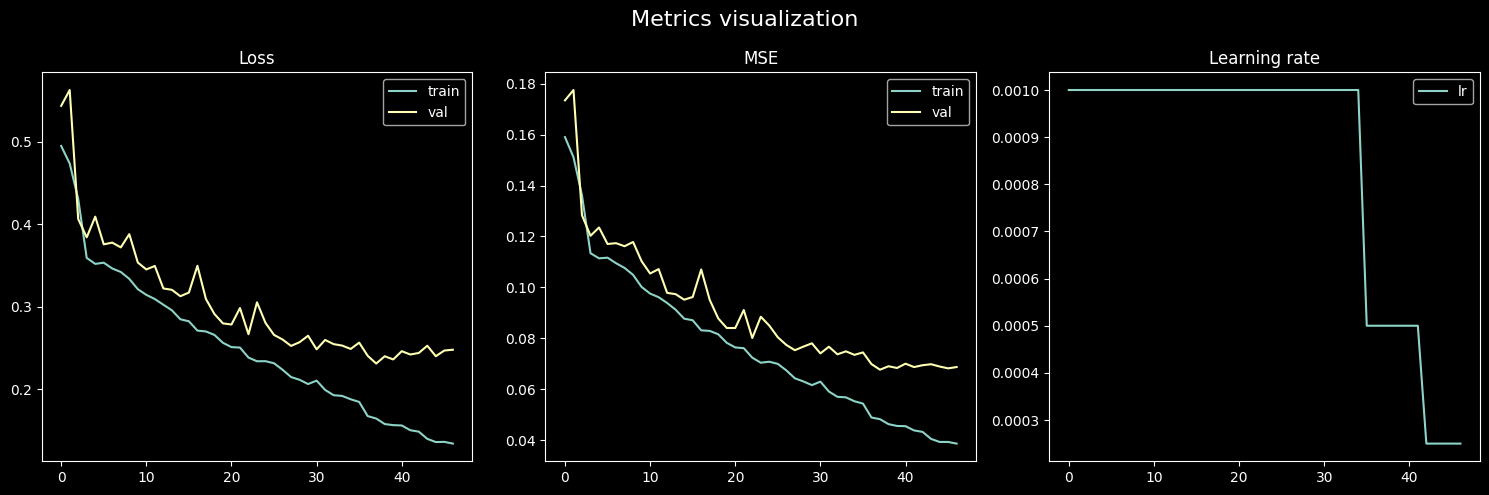

In [17]:
plt.style.use('dark_background')

plt.figure(figsize=(15, 5))
plt.suptitle(f"Metrics visualization", fontsize=16)

plt.subplot(131)
plt.title("Loss")
plt.plot(metrics_dict['train_loss_list'], label='train')
plt.plot(metrics_dict['val_loss_list'], label='val')
plt.legend()

plt.subplot(132)
plt.title("MSE")
plt.plot(metrics_dict['train_mse_list'], label='train')
plt.plot(metrics_dict['val_mse_list'], label='val')
plt.legend()

plt.subplot(133)
plt.title("Learning rate")
plt.plot(metrics_dict['lr_list'], label='lr')
plt.legend()

plt.tight_layout()
plt.show()

test_loss: 0.3521 | train_mse: 0.1047


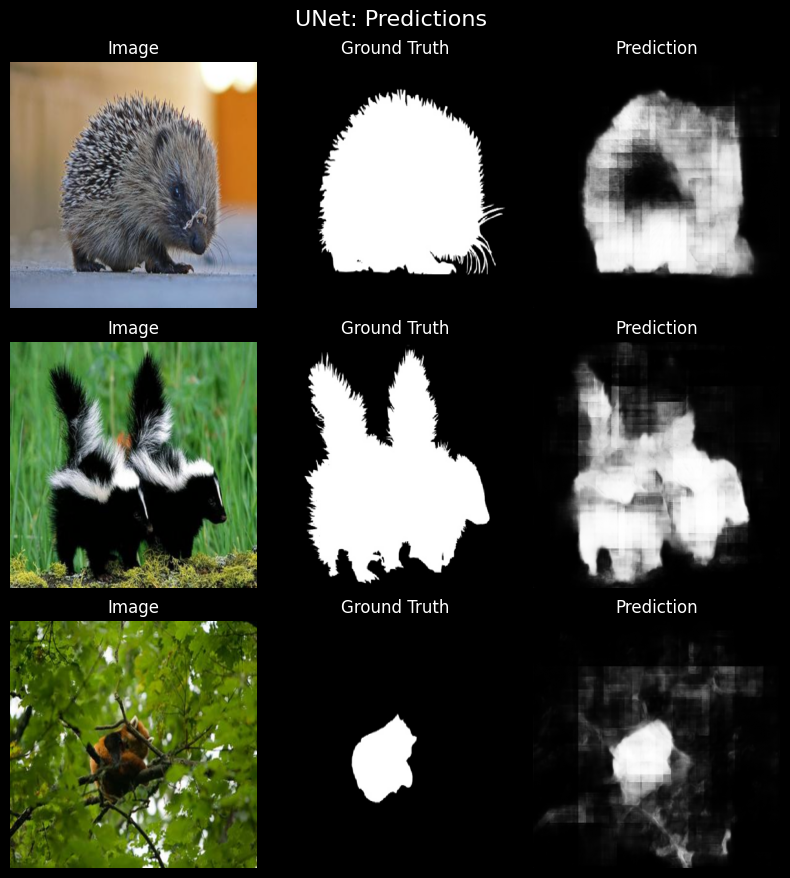

In [18]:
test_loss, test_mse = eval_epoch(model, test_loader, criterion)
print(f"test_loss: {test_loss:.4f} | train_mse: {test_mse:.4f}")
visualize_predictions(model, test_loader, device, epoch=None, n=3)

# 8. Fine-tunning dataset

In [19]:
class AIM500_dataset(Dataset):
    def __init__(self, data_path, transforms = None, pairs = None):
        self.data_path = data_path
        self.transforms = transforms
        self.all_pairs = pairs if pairs is not None else self.collect_pairs()

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, index):
        img_path, mask_path = self.all_pairs[index]

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        mask = mask.float() / 255.0
        mask = mask.unsqueeze(0)

        return  {
            'img':img,
            'mask':mask    
        }

    def collect_pairs(self):
        all_pairs = []

        image_dir = os.path.join(self.data_path, "original")
        mask_dir = os.path.join(self.data_path, "mask")

        for image_filename in sorted(os.listdir(image_dir)):
            img_path = os.path.join(image_dir, image_filename)

            img_png = os.path.splitext(image_filename)[0] + ".png"
            mask_path = os.path.join(mask_dir, img_png)

            if not os.path.exists(mask_path):
                continue
            
            all_pairs.append((img_path, mask_path))
        
        return all_pairs

In [20]:
AIM500_DATA_PATH = '/kaggle/input/dataset-matting/AIM-500-20251128T092629Z-1-001/AIM-500'

train_transforms = A.Compose([
    A.Resize(512, 512),

    A.HorizontalFlip(p=0.5),                     
    A.Affine(
        translate_percent=(0.05, 0.05), scale=(0.9, 1.1), 
        rotate=(-15, 15), p=0.5
    ),
    
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.7)
    ], p=0.5),


    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



FT_dataset = AIM500_dataset(AIM500_DATA_PATH, transforms = None)

full_pairs = FT_dataset.all_pairs

FT_dataset_len = len(FT_dataset)
FT_train_len = int(FT_dataset_len * 0.7)
FT_val_len = int(FT_dataset_len * 0.15)
FT_test_len = FT_dataset_len - FT_train_len - FT_val_len

train_pairs = full_pairs[:FT_train_len]
val_pairs = full_pairs[FT_train_len:FT_train_len + FT_val_len]
test_pairs = full_pairs[FT_train_len + FT_val_len:]

FT_train_dataset = AIM500_dataset(AIM500_DATA_PATH, transforms=train_transforms, pairs=train_pairs)
FT_val_dataset = AIM500_dataset(AIM500_DATA_PATH, transforms=val_test_transforms, pairs=val_pairs)
FT_test_dataset = AIM500_dataset(AIM500_DATA_PATH, transforms=val_test_transforms, pairs=test_pairs)

FT_train_loader = DataLoader(FT_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
FT_val_loader = DataLoader(FT_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
FT_test_loader = DataLoader(FT_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 9. Fine-tunning

In [43]:
class BCEl1_Loss(nn.Module):
    def __init__(self, l1_weight=1.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.l1_weight = l1_weight
    def forward(self, target, pred):
        bce_loss = self.bce(pred, target) 
        l1_loss = torch.mean(torch.abs(torch.sigmoid(pred) - target))

        loss = bce_loss + self.l1_weight * l1_loss
        
        return loss

In [21]:
FT_BEST_MODEL_SAVE_DIR = "FT_best_models"
FT_LR_SCHEDULER_PATIENCE = 2
FT_EARLYSTOPPING_PATIENCE = 7

FT_EPOCHS = 60
FT_LR = 1e-4
FT_MIN_DELTA = 1e-4

FT_optimizer = optim.Adam(model.parameters(), lr=FT_LR)
FT_criterion = nn.BCEWithLogitsLoss()
FT_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    FT_optimizer,
    mode='min',
    factor=0.6,
    patience=FT_LR_SCHEDULER_PATIENCE,
    min_lr=1e-6
)
FT_earlystopping = EarlyStopping(
    patience=FT_EARLYSTOPPING_PATIENCE,
    min_delta=FT_MIN_DELTA,
    best_model_dir=FT_BEST_MODEL_SAVE_DIR,
    verbose=True
)

Лучшая модель успешно сохранена в папку FT_best_models как best_model_1epoch.pt
[1/60] train_loss: 0.2669 | train_mse: 0.0741 | val_loss: 0.2419 | val_mse: 0.0671 | lr: 0.0001 ||| best_val_loss: 0.241859


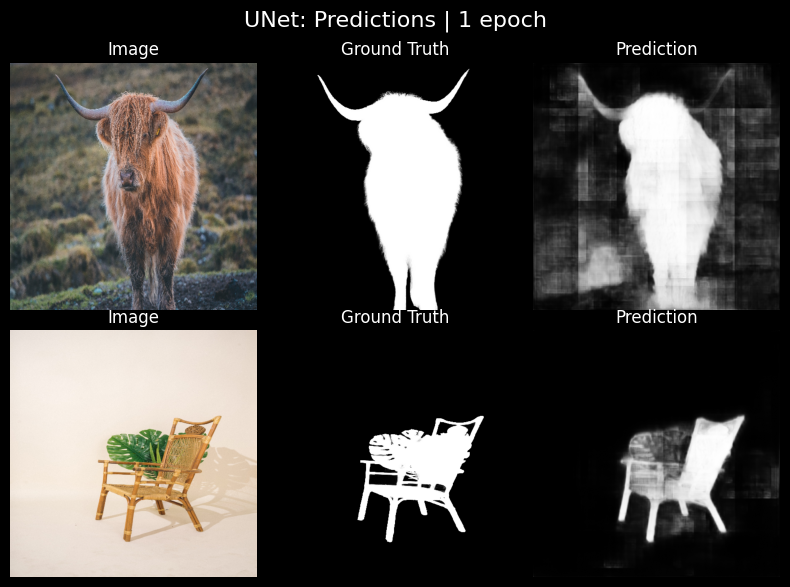

Лучшая модель успешно сохранена в папку FT_best_models как best_model_2epoch.pt
[2/60] train_loss: 0.2404 | train_mse: 0.0669 | val_loss: 0.2221 | val_mse: 0.0611 | lr: 0.0001 ||| best_val_loss: 0.222099


Лучшая модель успешно сохранена в папку FT_best_models как best_model_3epoch.pt
[3/60] train_loss: 0.2334 | train_mse: 0.0649 | val_loss: 0.2187 | val_mse: 0.0607 | lr: 0.0001 ||| best_val_loss: 0.218745


Лучшая модель успешно сохранена в папку FT_best_models как best_model_4epoch.pt
[4/60] train_loss: 0.2306 | train_mse: 0.0634 | val_loss: 0.2120 | val_mse: 0.0584 | lr: 0.0001 ||| best_val_loss: 0.212036


Лучшая модель успешно сохранена в папку FT_best_models как best_model_5epoch.pt
[5/60] train_loss: 0.2224 | train_mse: 0.0615 | val_loss: 0.2100 | val_mse: 0.0579 | lr: 0.0001 ||| best_val_loss: 0.209974


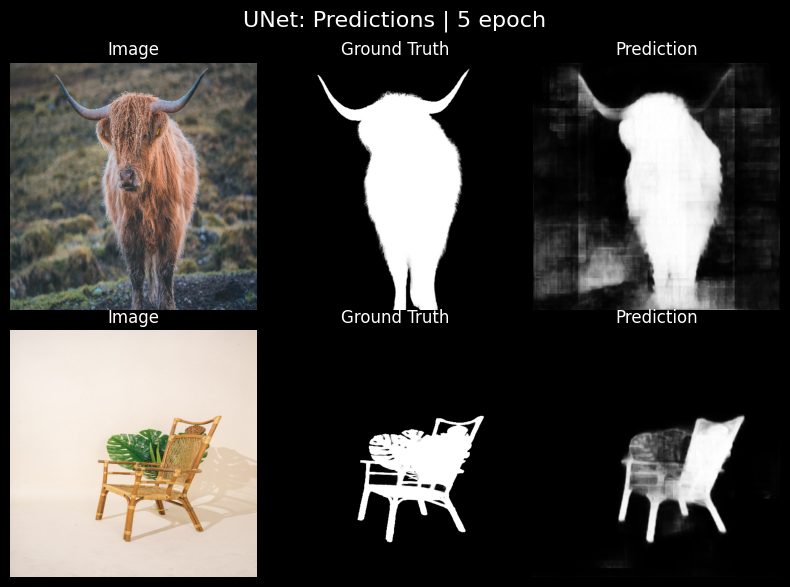

Лучшая модель успешно сохранена в папку FT_best_models как best_model_6epoch.pt
[6/60] train_loss: 0.2206 | train_mse: 0.0607 | val_loss: 0.2082 | val_mse: 0.0578 | lr: 0.0001 ||| best_val_loss: 0.208185


Лучшая модель успешно сохранена в папку FT_best_models как best_model_7epoch.pt
[7/60] train_loss: 0.2144 | train_mse: 0.0587 | val_loss: 0.2037 | val_mse: 0.0561 | lr: 0.0001 ||| best_val_loss: 0.203676


[8/60] train_loss: 0.2122 | train_mse: 0.0581 | val_loss: 0.2039 | val_mse: 0.0563 | lr: 0.0001 ||| best_val_loss: 0.203676


[9/60] train_loss: 0.2048 | train_mse: 0.0556 | val_loss: 0.2046 | val_mse: 0.0566 | lr: 0.0001 ||| best_val_loss: 0.203676


[10/60] train_loss: 0.2050 | train_mse: 0.0553 | val_loss: 0.2085 | val_mse: 0.0584 | lr: 6e-05 ||| best_val_loss: 0.203676


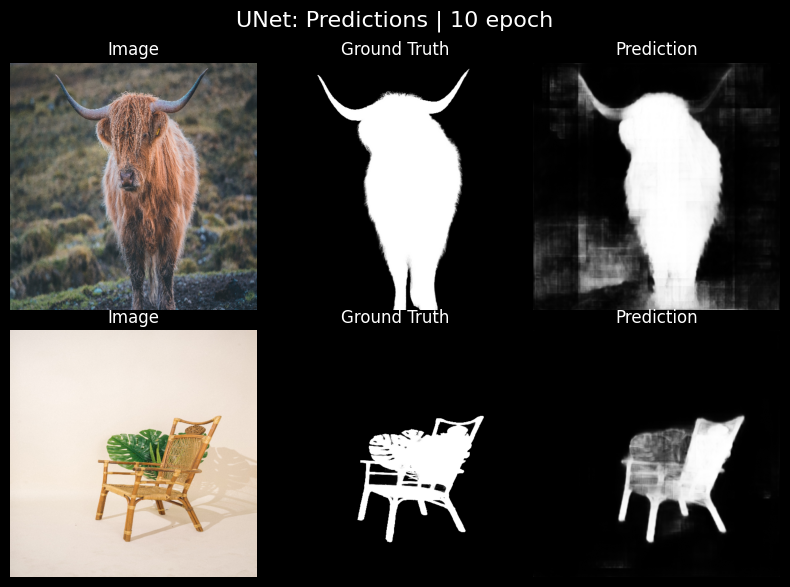

Лучшая модель успешно сохранена в папку FT_best_models как best_model_11epoch.pt
[11/60] train_loss: 0.2011 | train_mse: 0.0547 | val_loss: 0.2020 | val_mse: 0.0558 | lr: 6e-05 ||| best_val_loss: 0.201978


[12/60] train_loss: 0.2012 | train_mse: 0.0543 | val_loss: 0.2028 | val_mse: 0.0559 | lr: 6e-05 ||| best_val_loss: 0.201978


Лучшая модель успешно сохранена в папку FT_best_models как best_model_13epoch.pt
[13/60] train_loss: 0.1999 | train_mse: 0.0542 | val_loss: 0.2001 | val_mse: 0.0551 | lr: 6e-05 ||| best_val_loss: 0.200136


[14/60] train_loss: 0.1922 | train_mse: 0.0516 | val_loss: 0.2013 | val_mse: 0.0556 | lr: 6e-05 ||| best_val_loss: 0.200136


[15/60] train_loss: 0.1891 | train_mse: 0.0509 | val_loss: 0.2052 | val_mse: 0.0569 | lr: 6e-05 ||| best_val_loss: 0.200136


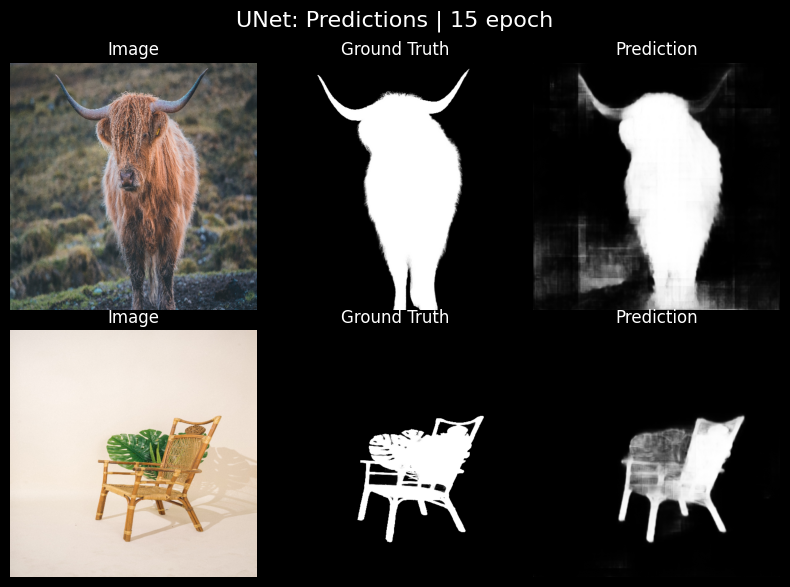

[16/60] train_loss: 0.1923 | train_mse: 0.0518 | val_loss: 0.2045 | val_mse: 0.0569 | lr: 3.6e-05 ||| best_val_loss: 0.200136


[17/60] train_loss: 0.1910 | train_mse: 0.0511 | val_loss: 0.2008 | val_mse: 0.0554 | lr: 3.6e-05 ||| best_val_loss: 0.200136


[18/60] train_loss: 0.1907 | train_mse: 0.0512 | val_loss: 0.2034 | val_mse: 0.0562 | lr: 3.6e-05 ||| best_val_loss: 0.200136


[19/60] train_loss: 0.1883 | train_mse: 0.0505 | val_loss: 0.2022 | val_mse: 0.0559 | lr: 2.16e-05 ||| best_val_loss: 0.200136


[20/60] train_loss: 0.1872 | train_mse: 0.0499 | val_loss: 0.2009 | val_mse: 0.0554 | lr: 2.16e-05 ||| best_val_loss: 0.200136


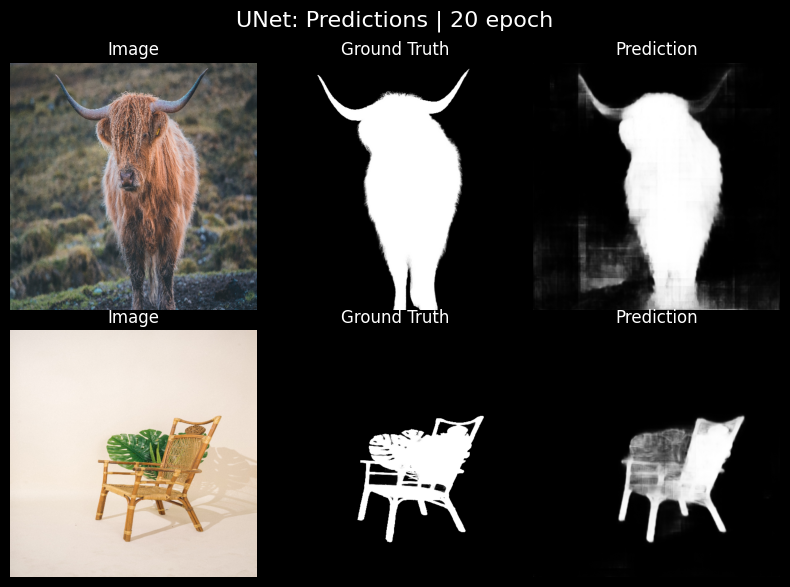

Stopped on epoch: 20


In [22]:
for epoch in range(1, FT_EPOCHS + 1):
    FT_train_loop = tqdm(FT_train_loader, leave = False)
    
    train_loss, train_mse = train_epoch(model, FT_train_loop, FT_optimizer, FT_criterion, FT_EPOCHS)
    
    val_loss, val_mse = eval_epoch(model, FT_val_loader, FT_criterion)
    
    FT_earlystopping.step(val_loss, model, epoch)
    FT_lr_scheduler.step(val_loss)
    lr = FT_lr_scheduler._last_lr[0]
    
    print(f"[{epoch}/{FT_EPOCHS}] train_loss: {train_loss:.4f} | train_mse: {train_mse:.4f} | val_loss: {val_loss:.4f} | val_mse: {val_mse:.4f} | lr: {lr} ||| best_val_loss: {FT_earlystopping.best_value:.6f}")
    
    if epoch == 1 or epoch % 5 == 0:
        visualize_predictions(model, FT_val_loader, device, epoch, n=2)
    
    if FT_earlystopping.should_stop == True:
        print(f"Stopped on epoch: {epoch}")
        break

# 10. Fine-tunning results

FT_test_loss: 0.2254 | FT_train_mse: 0.0604


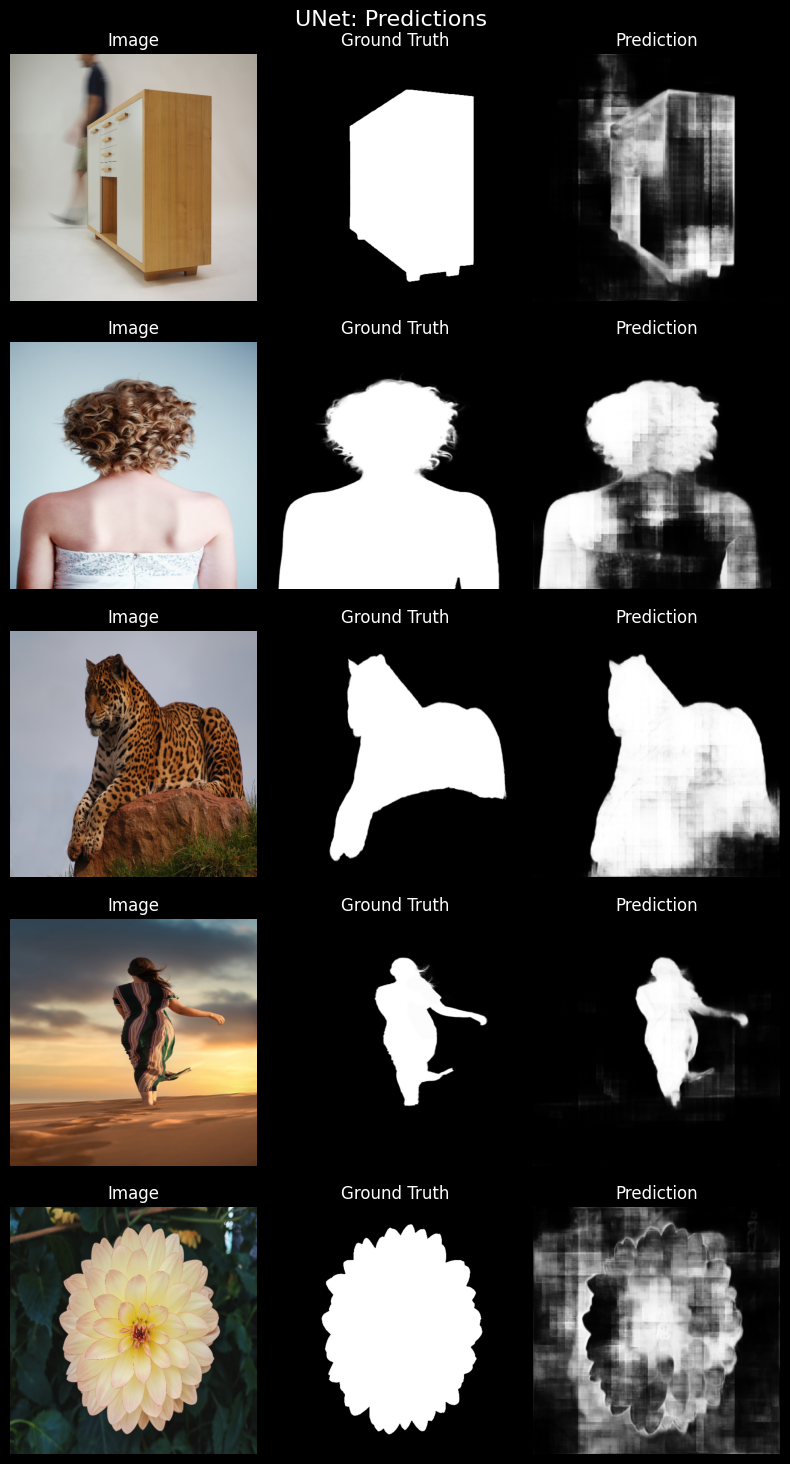

In [23]:
test_loss, test_mse = eval_epoch(model, FT_test_loader, criterion)
print(f"FT_test_loss: {test_loss:.4f} | FT_train_mse: {test_mse:.4f}")
visualize_predictions(model, FT_test_loader, device, epoch=None, n=5)

# 11. Inference on test data

In [24]:
import pandas as pd
from PIL import Image
import base64
import io
from pathlib import Path

In [27]:
def predict_single_image(img_path):
    with torch.no_grad():
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = val_test_transforms(image=img)['image']
        
        x = img.unsqueeze(dim=0).to(device)
    
        pred = torch.sigmoid(model(x))
    
        mask = pred[0, 0].detach().cpu().numpy()
        mask = (mask * 255).clip(0, 255).astype(np.uint8)
        mask = np.array(Image.fromarray(mask).resize((1024, 1024), resample=Image.BILINEAR))

    return mask

In [28]:
test_dataset_dir = "/kaggle/input/samokat-data/test_dataset/orig_1024"
predicted_dir = Path("predicted")
predicted_dir.mkdir(exist_ok=True)

model.eval()
for file_name in sorted(os.listdir(test_dataset_dir)):
    img_path = os.path.join(test_dataset_dir, file_name)

    mask = predict_single_image(img_path)

    out_path = os.path.join(predicted_dir, f"{Path(file_name).stem}.png")

    Image.fromarray(mask, mode="L").save(out_path)

/tmp/ipykernel_55/1148588190.py:13: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(mask, mode="L").save(out_path)
